In [1]:
# starting over because I've confused my self yay!

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import seaborn as sns
from scipy.stats import ttest_ind

import sys
sys.path.append('../../../')

from src.utils.error_utils import get_nan_prec
from utils2 import get_dist_frames

node = 3 # ['nose','earL','earR','headBase','foreLimbL','foreLimbR','hindLimbL','hindLimbR','tailBase','tailMid','tailTip','leverTop','leverBottom','magTop','magBottom']

In [3]:
root = '/gpfs/radev/pi/saxena/aj764/Training_LARGEARENA_Individual/'
sessions = os.listdir(root)

In [4]:
df = pd.DataFrame(columns=['vid', 'session', 'animal id', 'month', 'day', 'year'])

In [5]:
# get all of the videos from large arean training
index = 0
for s in sessions:
    if os.path.isdir(root + s):
        files = os.listdir(root + s)
        files = [f[:-4] for f in files if 'mp4' in f]
        for f in files:
            if os.path.exists(root + s + '/Tracking/h5_not_corrected/' + f + 'predictions.h5'):
                animal_id = f.split('_')[3]
            
                month, day, year = f[:2], f[2:4], f[4:6]
                df.loc[index] = [f, s, animal_id, month, day, year]
                index += 1
    
    # get initial nan, get corrected nan, get animal id
    # sort by animal id
    # see how many vids each animal has
    # see how many good vids each animal has
    # focus on kl and eb!

In [6]:
# sort videos by date and only take videos from the EB and KL cohorts
id_df = df.sort_values(by=['animal id', 'year', 'month', 'day'])
id_df = id_df[id_df['animal id'].str.contains('EB') | id_df['animal id'].str.contains('KL')]
id_df['animal group'] = id_df['animal id'].apply(lambda x: 'EB' if 'EB' in x else ('KL' if 'KL' in x else 'Unknown'))

In [7]:
id_df

,vid,session,animal id,month,day,year,animal group
886,032624_ISTRAIN_LARGEARENA_EB001_Camera4,032624,EB001,03,26,24,EB
1259,032524_ISTRAIN_LARGEARENA_EB001R_Camera1,032524,EB001R,03,25,24,EB
155,032824_ISTRAIN_LARGEARENA_EB001R_Camera1,032824,EB001R,03,28,24,EB
1213,032924_ISTRAIN_LARGEARENA_EB001R_Camera1,032924,EB001R,03,29,24,EB
962,033024_ISTRAIN_LARGEARENA_EB001R_Camera1,033024,EB001R,03,30,24,EB
...,...,...,...,...,...,...,...
195,032424_PVTRAIN_LARGEARENA_KL008Y_Camera4,032424,KL008Y,03,24,24,KL
1252,032524_PVTRAIN_LARGEARENA_KL008Y_Camera4,032524,KL008Y,03,25,24,KL
885,032624_PVTRAIN_LARGEARENA_KL008Y_Camera3,032624,KL008Y,03,26,24,KL
495,032724_PVTRAIN_LARGEARENA_KL008Y_Camera3,032724,KL008Y,03,27,24,KL


In [8]:
for index, row in id_df.iterrows():
    with h5py.File(root + row['session'] + '/Tracking/h5_not_corrected/' + row['vid'] + 'predictions.h5','r') as f:
        locations = f["tracks"][:].T
        id_df.at[index, 'total'] = locations.shape[0]
        id_df.at[index, 'nan'] = np.sum(np.isnan(np.sum(locations[:, node, :, :], axis=1)))
        id_df.at[index, 'not nan'] = id_df.loc[index, 'total'] - id_df.loc[index, 'nan']
        id_df.at[index, 'center'] = len(get_dist_frames('center', locations, node))
        id_df.at[index, 'wall'] = len(get_dist_frames('wall', locations, node))
        id_df.at[index, 'corner'] = len(get_dist_frames('corner', locations, node))

        id_df.at[index, 'nan prec'] = 100 * id_df.loc[index, 'nan'] / id_df.loc[index, 'total']
        id_df.at[index, 'center prec'] = 100 * id_df.loc[index, 'center'] / id_df.loc[index, 'total']
        id_df.at[index, 'norm center prec'] = 100 * id_df.loc[index, 'center'] / id_df.loc[index, 'not nan']
        id_df.at[index, 'wall prec'] = 100 * id_df.loc[index, 'wall'] / id_df.loc[index, 'total']
        id_df.at[index, 'norm wall prec'] = 100 * id_df.loc[index, 'wall'] / id_df.loc[index, 'not nan']
        id_df.at[index, 'corner prec'] = 100 * id_df.loc[index, 'corner'] / id_df.loc[index, 'total']
        id_df.at[index, 'norm corner prec'] = 100 * id_df.loc[index, 'corner'] / id_df.loc[index, 'not nan']

/gpfs/radev/project/saxena/aj764/wts/scripts/notebooks/anxiety_metrics/utils2.py:14: RuntimeWarning: All-NaN slice encountered
  xmin, xmax = np.nanmin(locations[:, node, 0, :]), np.nanmax(locations[:, node, 0, :])
/gpfs/radev/project/saxena/aj764/wts/scripts/notebooks/anxiety_metrics/utils2.py:15: RuntimeWarning: All-NaN slice encountered
  ymin, ymax = np.nanmin(locations[:, node, 1, :]), np.nanmax(locations[:, node, 1, :])
/tmp/ipykernel_1775754/1651218714.py:13: RuntimeWarning: invalid value encountered in scalar divide
  id_df.at[index, 'norm center prec'] = 100 * id_df.loc[index, 'center'] / id_df.loc[index, 'not nan']
/tmp/ipykernel_1775754/1651218714.py:15: RuntimeWarning: invalid value encountered in scalar divide
  id_df.at[index, 'norm wall prec'] = 100 * id_df.loc[index, 'wall'] / id_df.loc[index, 'not nan']
/tmp/ipykernel_1775754/1651218714.py:17: RuntimeWarning: invalid value encountered in scalar divide
  id_df.at[index, 'norm corner prec'] = 100 * id_df.loc[index, 'corn

In [9]:
id_df[id_df['animal id'] == 'EB003']

,vid,session,animal id,month,day,year,animal group,total,nan,not nan,center,wall,corner,nan prec,center prec,norm center prec,wall prec,norm wall prec,corner prec,norm corner prec
898,032624_ISTRAIN_LARGEARENA_EB003_Camera4,032624,EB003,03,26,24,EB,37.0,37.0,0.0,0.0,0.0,0.0,100.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN
521,032724_ISTRAIN_LARGEARENA_EB003_Camera4,032724,EB003,03,27,24,EB,108006.0,54589.0,53417.0,12149.0,33846.0,13719.0,50.542562,11.248449,22.743696,31.337148,63.361851,12.702072,25.682835


In [11]:
unique_ids = sorted(list(set(id_df['animal id'])))

In [12]:
len(unique_ids)

84

In [13]:
for ids in unique_ids:
    if id_df[id_df['animal id'] == ids].shape[0] > 1 and ids != 'EB003': # one of these vids has 100% nan...
        animal_df = id_df[id_df['animal id'] == ids]
        first = animal_df.head(1)
        last = animal_df.tail(1)
        id_df.at[first.index.item(), 'order'] = 'first'
        id_df.at[last.index.item(), 'order'] = 'last'

In [14]:

list(id_df.columns)[14:-1]

['center prec',
 'norm center prec',
 'wall prec',
 'norm wall prec',
 'corner prec',
 'norm corner prec']

0.045981251926152183


/tmp/ipykernel_1775754/2011831930.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


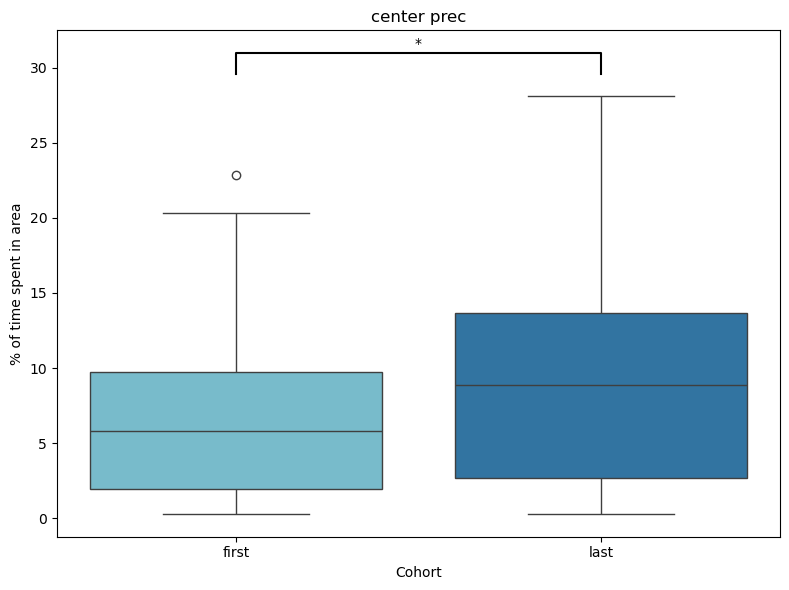

0.4490064919912421


/tmp/ipykernel_1775754/2011831930.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


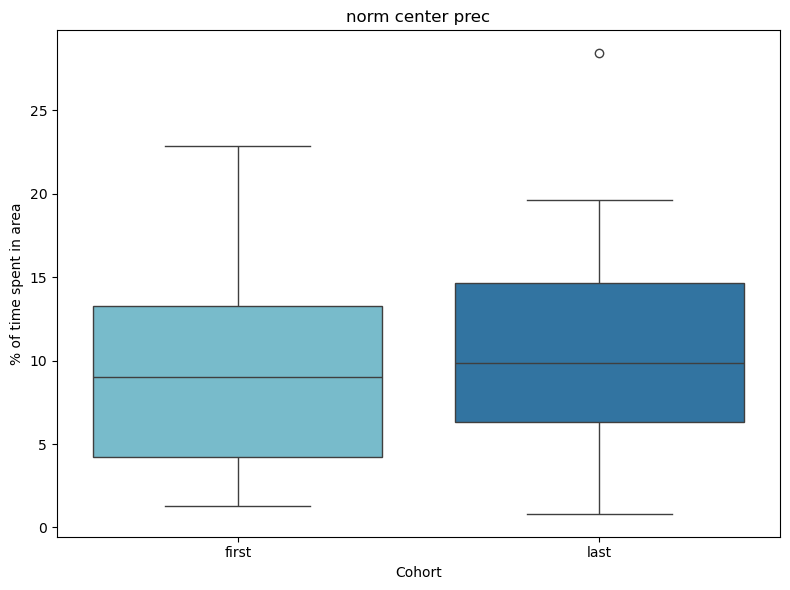

0.05261059787459318


/tmp/ipykernel_1775754/2011831930.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


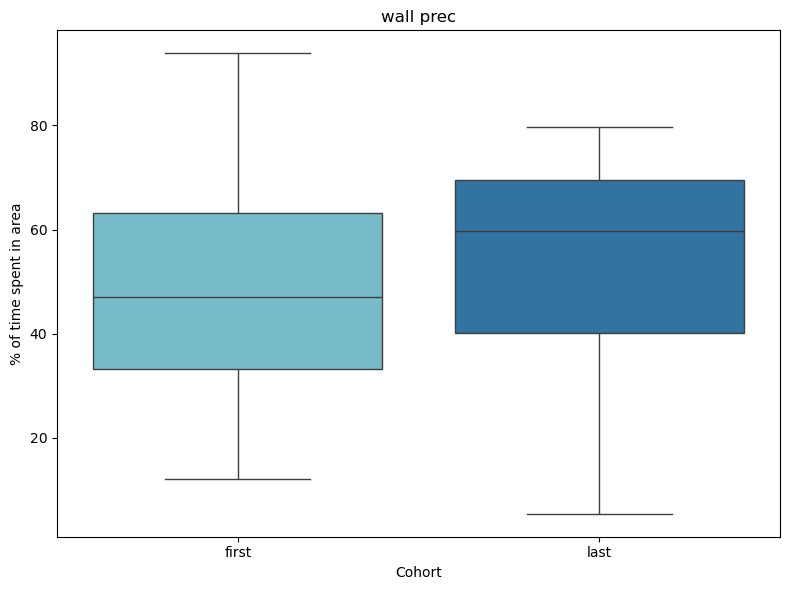

0.14563028419634583


/tmp/ipykernel_1775754/2011831930.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


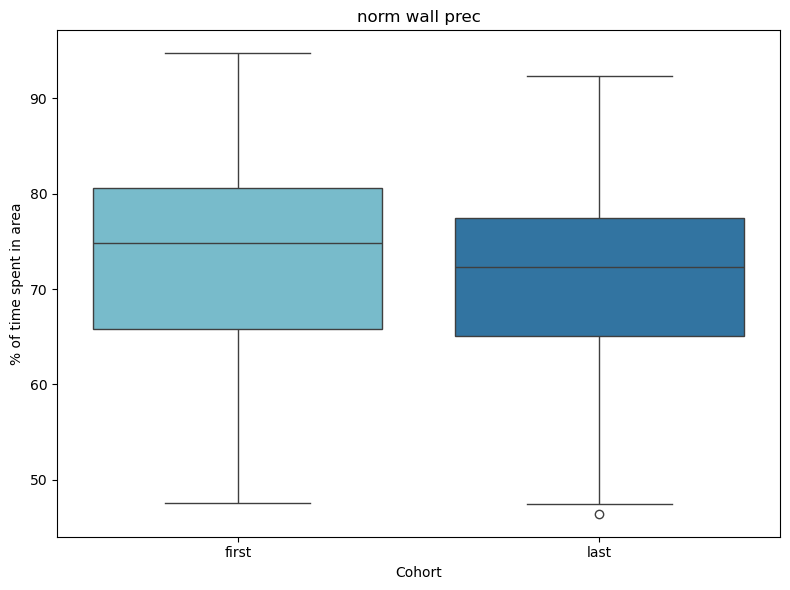

0.014329685484308822


/tmp/ipykernel_1775754/2011831930.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


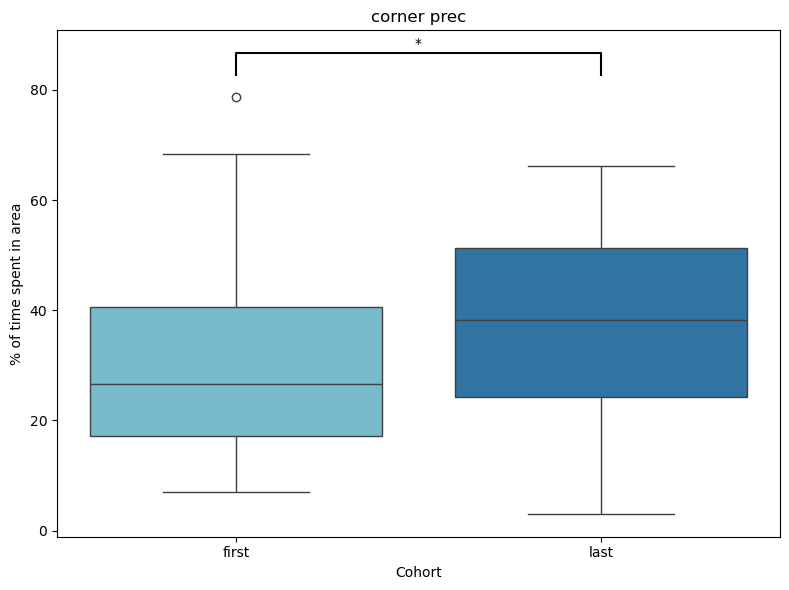

/tmp/ipykernel_1775754/2011831930.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


0.3209103481997379


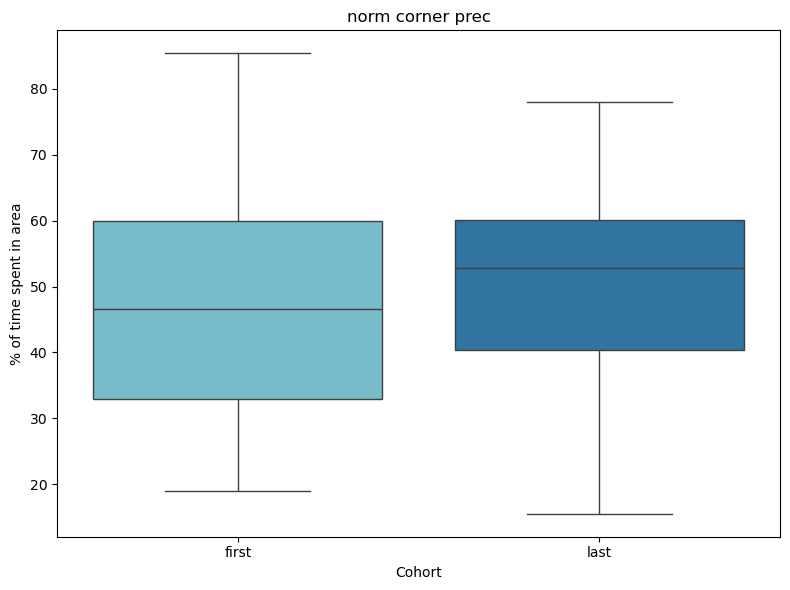

In [29]:
# combined
for data_name in list(id_df.columns)[14:-1]:
    order_df = id_df[(id_df['order'] == 'first') | (id_df['order'] == 'last')]
    box_colors = ['#6ac3d9', '#1f77b4']
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(
        x='order',
        y=data_name,
        data=order_df,
        palette=box_colors  # set custom fill colors
    )
    
    # Labeling
    plt.title(data_name)
    plt.xlabel("Cohort")
    plt.ylabel("% of time spent in area")
    
    # Get the two groups
    group1 = order_df[order_df['order'] == 'first'][data_name]
    group2 = order_df[order_df['order'] == 'last'][data_name]
    group1 = group1[group1 != np.inf]
    group2 = group2[group2 != np.inf]

    
    # Perform t-test
    t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
    print(p_val)
    
    # Add significance annotation if p < 0.05
    if p_val < 0.05:
        # Coordinates for the bars
        x1, x2 = 0, 1
        y, h, col = max(order_df[data_name]) * 1.05, max(order_df[data_name]) * 0.05, 'k'
    
        # Draw the lines
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        significance = '*' if p_val < 0.05 else 'n.s.'
        if p_val < 0.01:
            significance = '**'
        if p_val < 0.001:
            significance = '***'
        
        # Add text for significance level
        plt.text((x1 + x2) * 0.5, y + h + h * 0.1, significance, ha='center', va='bottom', color=col)
    
    plt.tight_layout()
    plt.show()

        
                

0.016116251277753853
0.053276473635060655


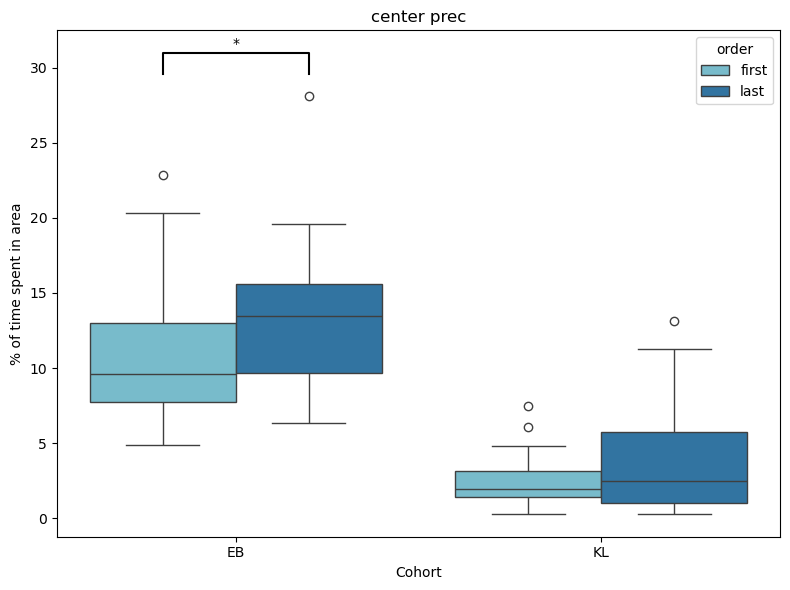

0.5573363010286854
0.027201019509520113


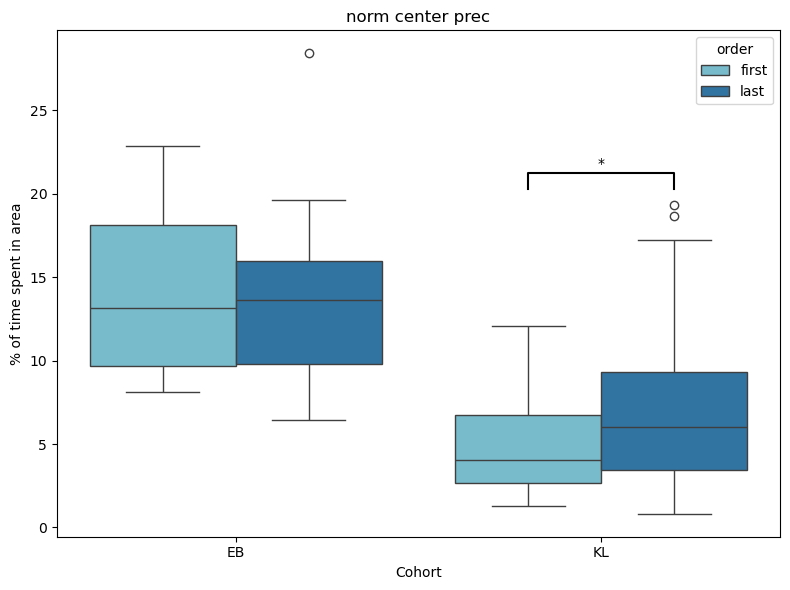

7.593459021542686e-06
0.5587687326599347


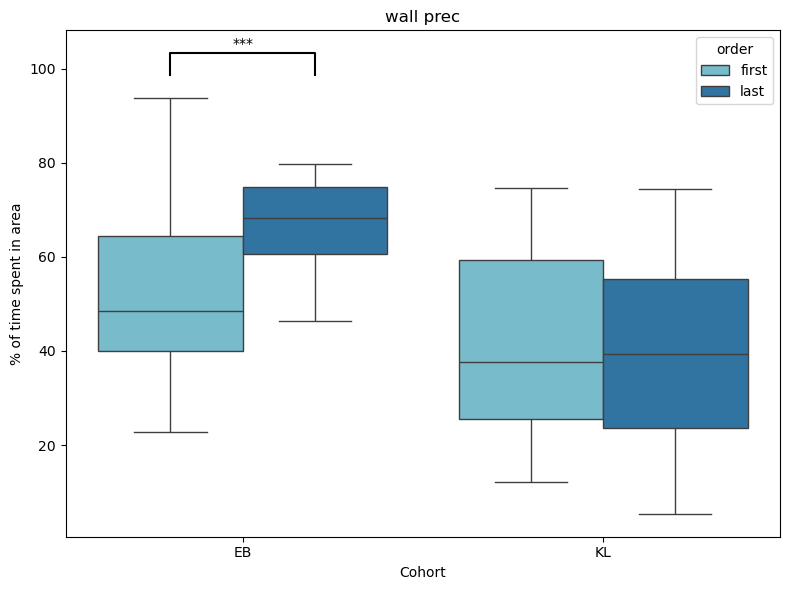

0.9331559380687633
0.010997261368526516


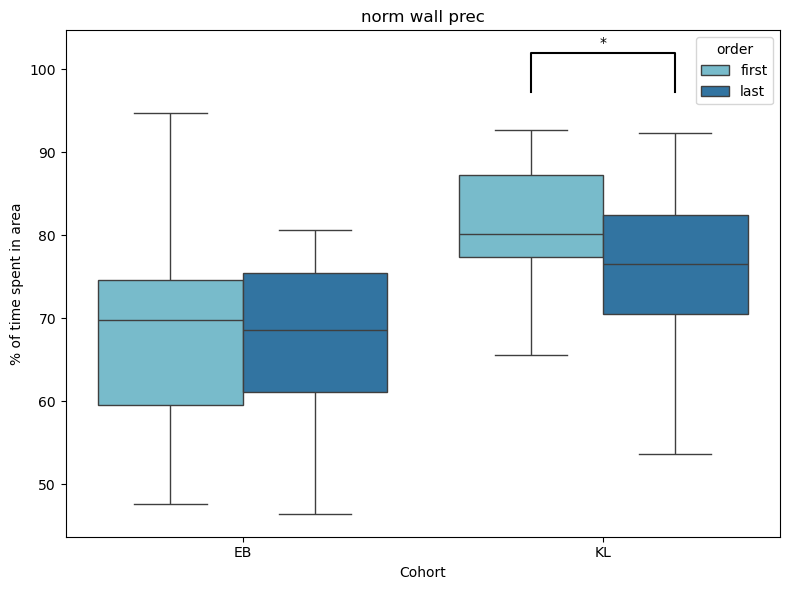

8.424895983222605e-05
0.9019127743045302


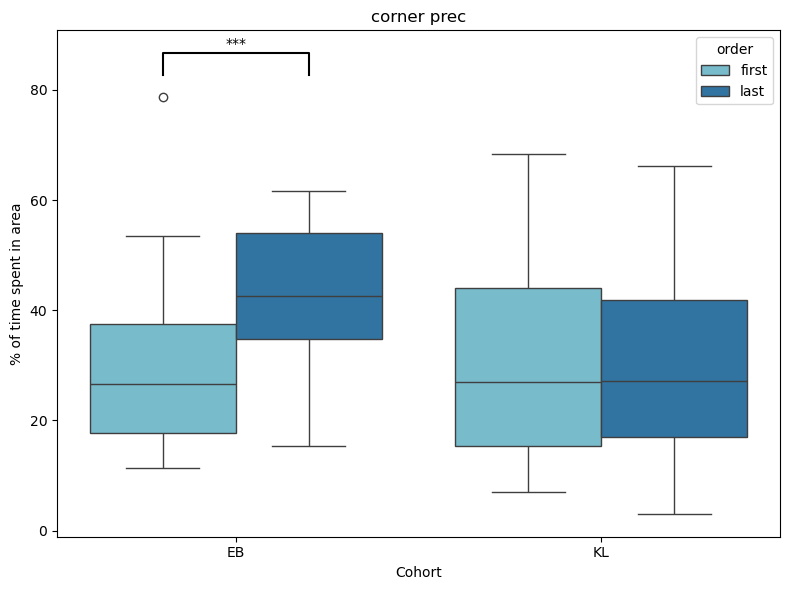

0.05269076449492796
0.8916437066897986


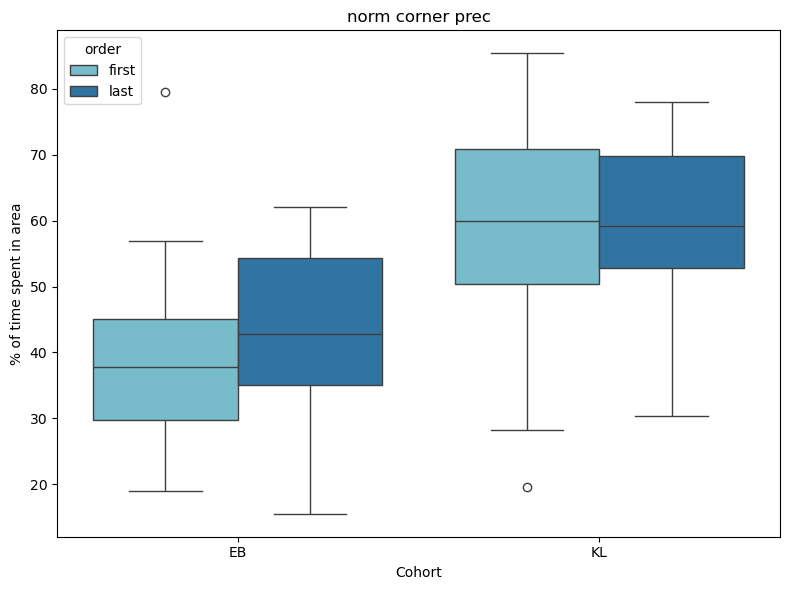

In [38]:
# by cohort
for data_name in list(id_df.columns)[14:-1]:
    order_df = id_df[(id_df['order'] == 'first') | (id_df['order'] == 'last')]
    box_colors = ['#6ac3d9', '#1f77b4']
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(
        x='animal group',
        y=data_name,
        hue='order',
        data=order_df,
        palette=box_colors  # set custom fill colors
    )
    
    # Labeling
    plt.title(data_name)
    plt.xlabel("Cohort")
    plt.ylabel("% of time spent in area")
    
    # Get the two groups
    for i, cohort in enumerate(order_df['animal group'].unique()):
        coh_df = order_df[order_df['animal group'] == cohort]
        group1 = coh_df[coh_df['order'] == 'first'][data_name]
        group2 = coh_df[coh_df['order'] == 'last'][data_name]
        group1 = group1[group1 != np.inf]
        group2 = group2[group2 != np.inf]
    
        
        # Perform t-test
        t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
        print(p_val)
        
        # Add significance annotation if p < 0.05
        if p_val < 0.05:
            # Coordinates for the bars
            x1, x2 = -0.2 + i, 0.2 + i
            y, h, col = max(coh_df[data_name]) * 1.05, max(coh_df[data_name]) * 0.05, 'k'
        
            # Draw the lines
            plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
            significance = '*' if p_val < 0.05 else 'n.s.'
            if p_val < 0.01:
                significance = '**'
            if p_val < 0.001:
                significance = '***'
            
            # Add text for significance level
            plt.text((x1 + x2) * 0.5, y + h + h * 0.1, significance, ha='center', va='bottom', color=col)
    
    plt.tight_layout()
    plt.show()

        
                

In [48]:

for ids in unique_ids:
    if ids != 'EB003': # one of these vids has 100% nan...
        animal_df = id_df[id_df['animal id'] == ids]
        count = 1
        for index, row in animal_df.iterrows():
            id_df.at[index, 'ord'] = count
            count +=1

In [59]:
vals

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]

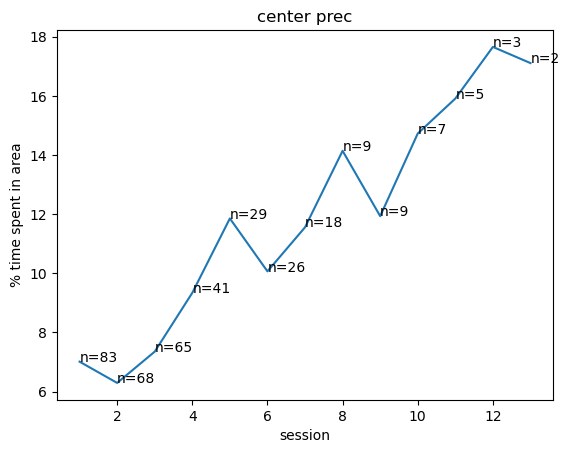

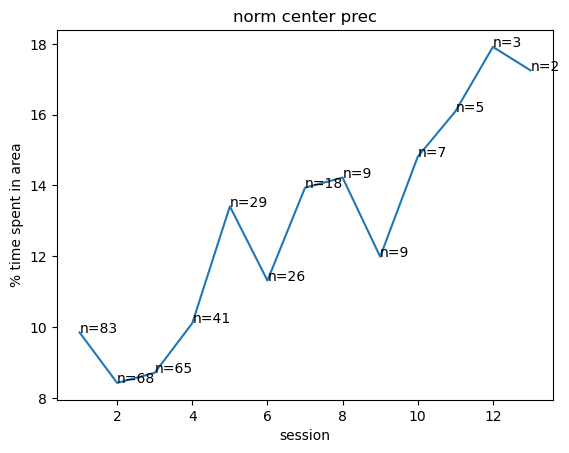

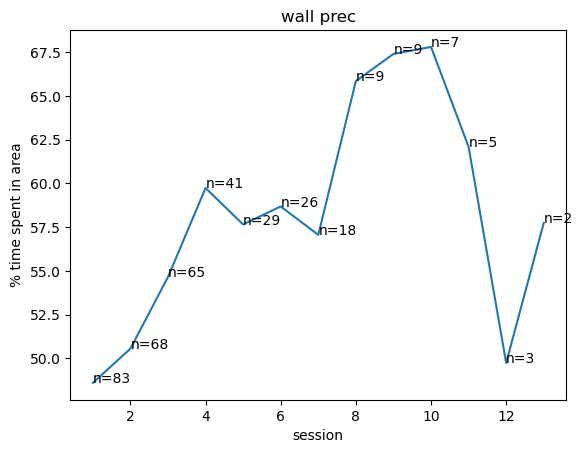

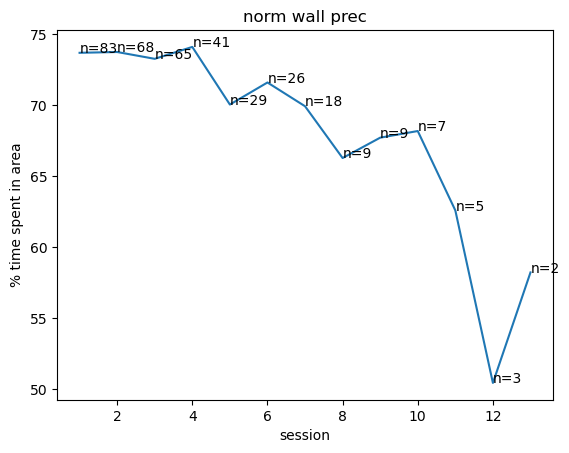

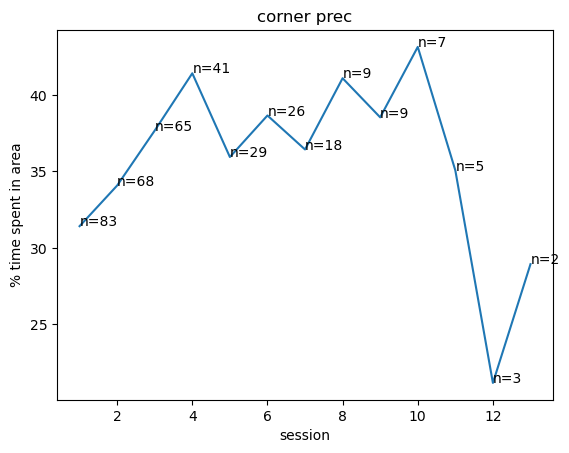

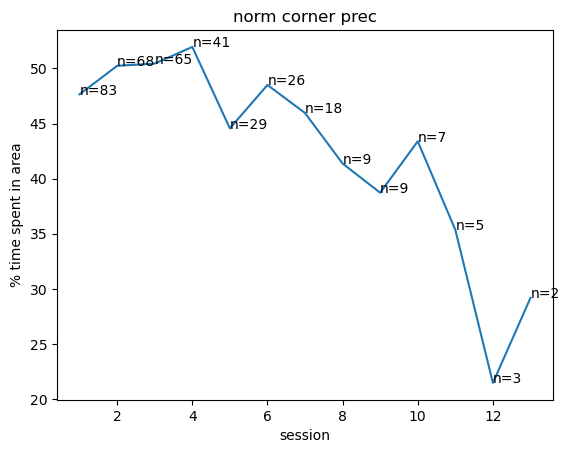

In [62]:
for data_name in list(id_df.columns)[14:-2]:
    vals = []
    means = []
    for val in sorted(id_df['ord'].unique()):
        if not np.isnan(val):
            mean = np.mean(id_df[id_df['ord'] == val][data_name])
            plt.text(val, mean, f'n={len(id_df[id_df['ord'] == val][data_name])}')
            vals.append(val)
            means.append(mean)
    plt.plot(vals, means)
    plt.title(data_name)
    plt.xlabel('session')
    plt.ylabel('% time spent in area')
    plt.show()
    

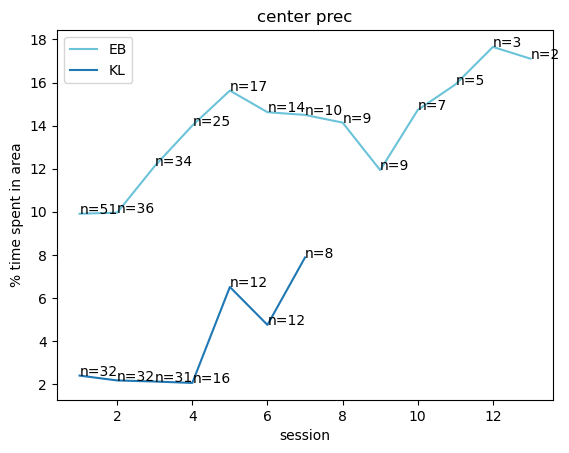

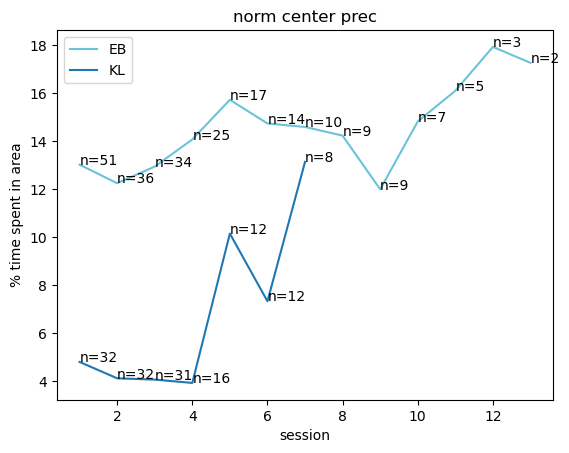

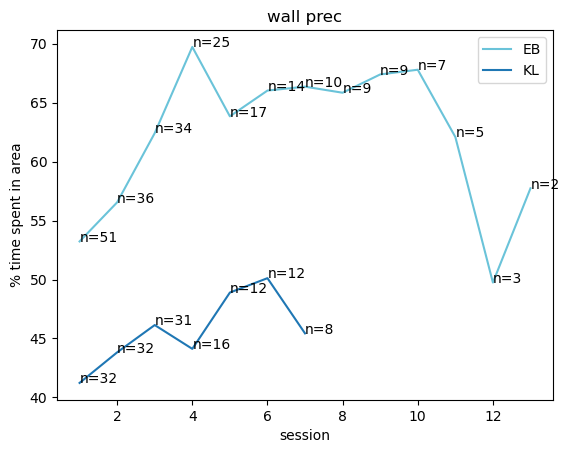

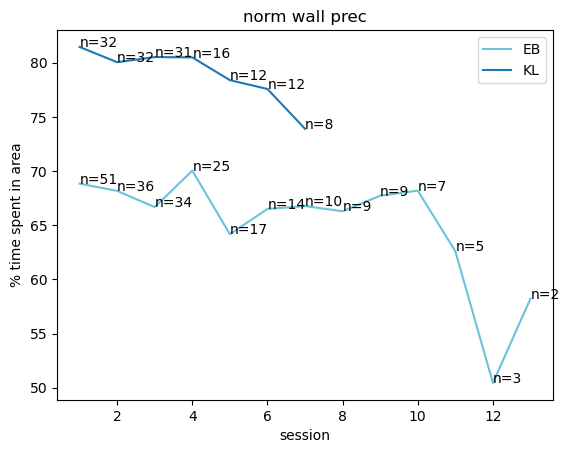

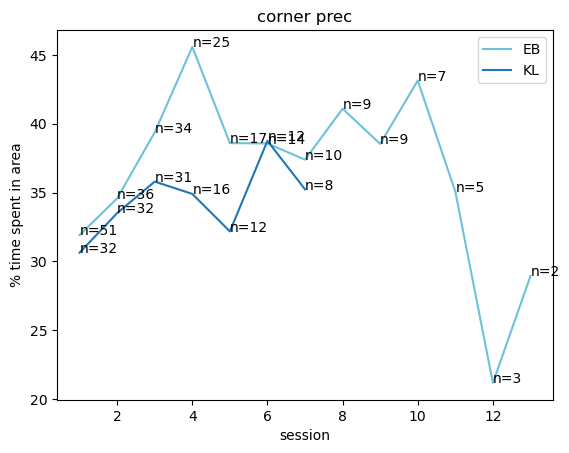

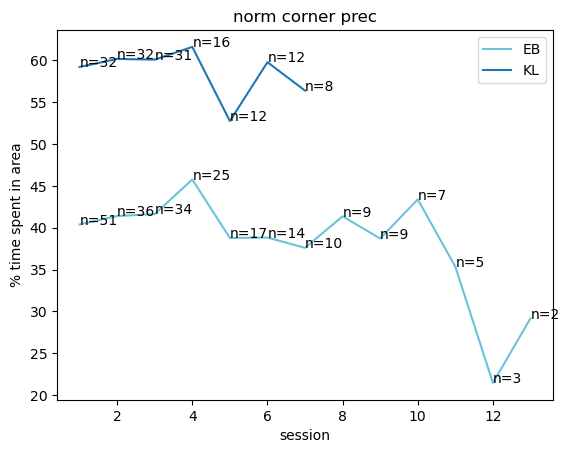

In [66]:
colors = ['#6ac3d9', '#1f77b4']
for data_name in list(id_df.columns)[14:-2]:
    for i, cohort in enumerate(id_df['animal group'].unique()):
        coh_df = id_df[id_df['animal group'] == cohort]
        # FILTER HERE
        vals = []
        means = []
        for val in sorted(coh_df['ord'].unique()):
            if not np.isnan(val):
                mean = np.mean(coh_df[coh_df['ord'] == val][data_name])
                plt.text(val, mean, f'n={len(coh_df[coh_df['ord'] == val][data_name])}')
                vals.append(val)
                means.append(mean)
        plt.plot(vals, means, color=colors[i], label=cohort)
    plt.title(data_name)
    plt.legend()
    plt.xlabel('session')
    plt.ylabel('% time spent in area')
    plt.show()